# Лабораторная работа 7. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Поиск шаблона на изображении
2. Локальные особенности. Особые точки.


In [1]:
%reset

In [2]:
import sys
#sys.path.append('../')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

# Изменим стандартный размер графиков matplotlib
WIDTH_SIZE = 15
HEIGHT_SIZE = 10
plt.rcParams["figure.figsize"] = [WIDTH_SIZE, HEIGHT_SIZE]

# Поиск шаблона на изображении методом выделения особых точек (SIFT)

In [3]:
# Загружаем изображение
rgb_img = cv2.imread('./crowd.jpg')
template = cv2.imread('./guy.jpg')


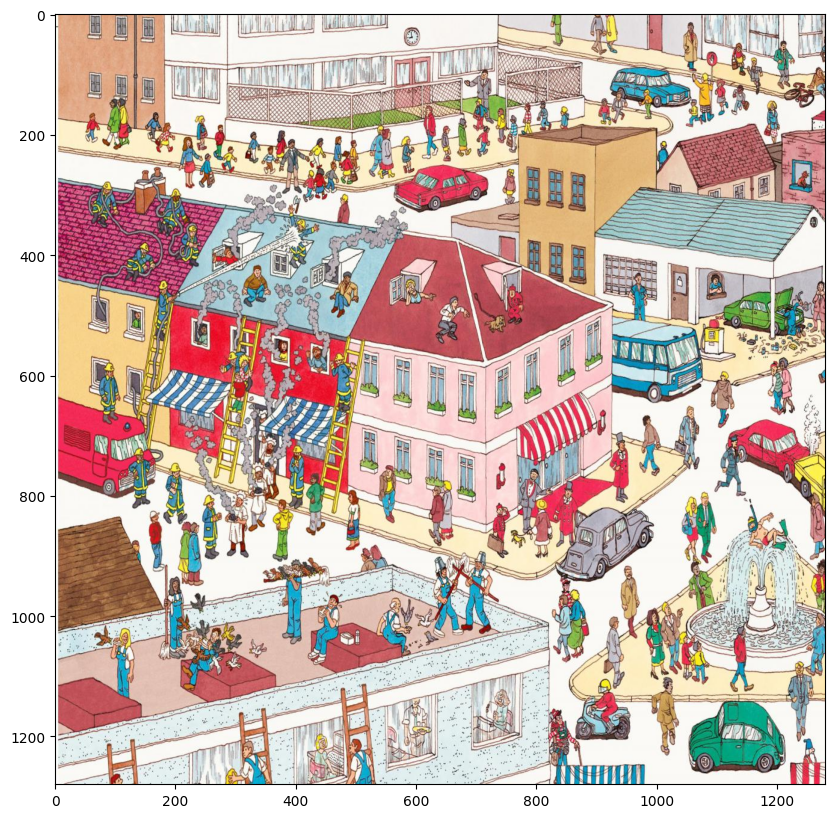

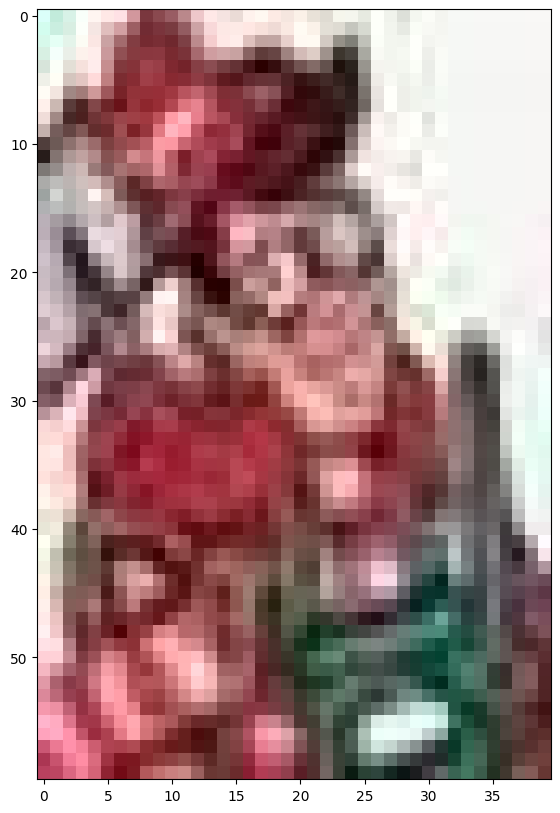

In [4]:
plt.figure()
plt.imshow(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB))
# Преобразуем изображение в оттенки серого
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

# Загружаем шаблон

plt.figure()
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

# Преобразуем в оттенки серого
gray_templ = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

(3.4902255535125732, 640.2984008789062)
2.3285255432128906
177.55014038085938
0.03391517326235771
2.3285255432128906


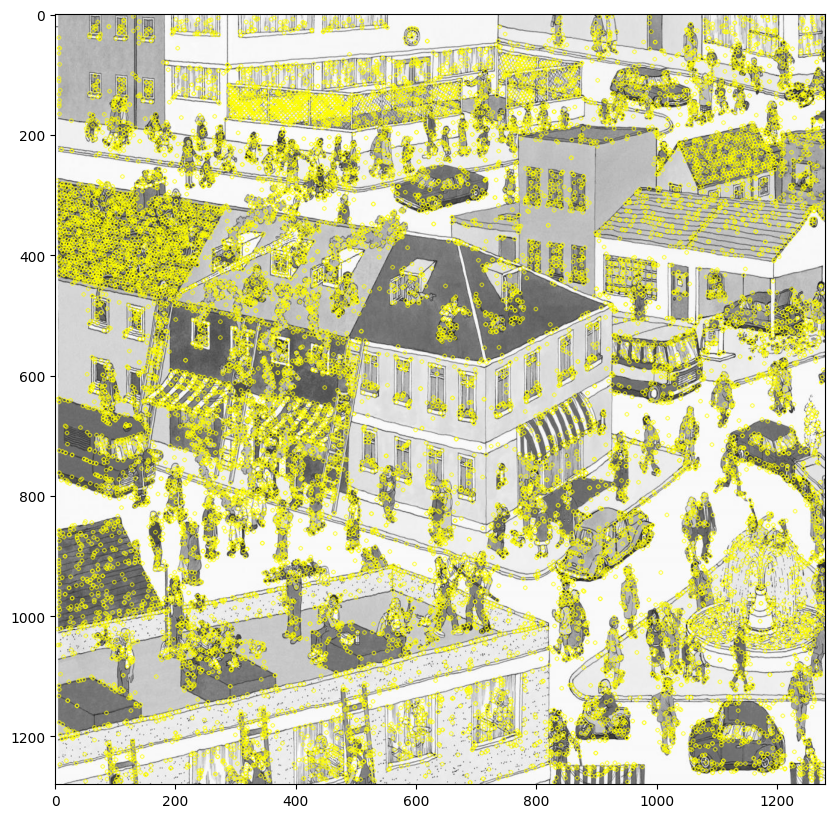

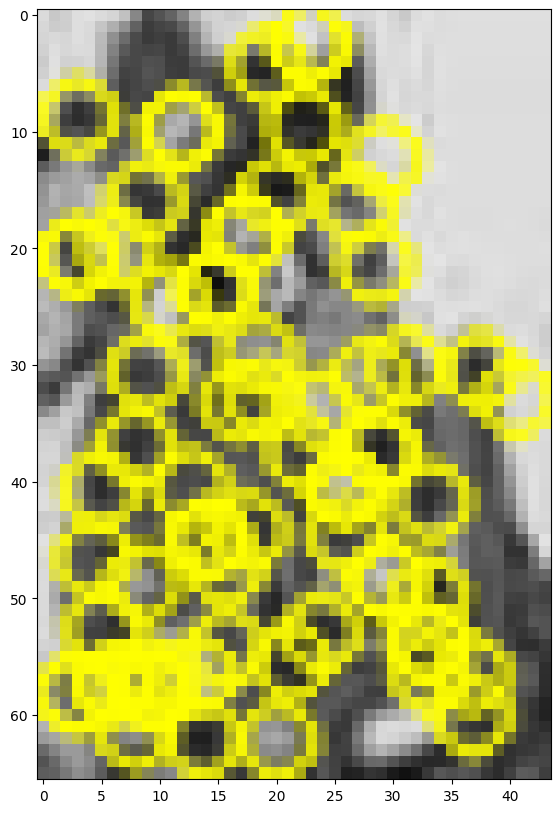

In [5]:
# Преобразуем и вносим небольшие изменения в шаблон

    # Преобразуем в оттенки серого
scale = 1.1 # масштаб изменения размеров
scBr = 0.9 # коэффициент изменения яркости

template_scale = cv2.resize(np.uint8(0.9*cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)),
           (int(template.shape[1]*scale), int(template.shape[0]*scale)), interpolation = cv2.INTER_AREA)

# Создаем детектор особых точек
sift = cv2.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create() # В зависимости от версии opencv может работать эта команда

# Запускаем детектор на изображении и на шаблоне
# Метод возвращает список особых точек и их дескрипторов
k_1, des_1 = sift.detectAndCompute(gray_img, None)
k_2, des_2 = sift.detectAndCompute(template_scale, None)

# Каждая особая точка имеет несколько параметров, таких как координаты,
# размер, угол ориентации, мощность отклика и размер области особой точки.
print(k_1[1].pt)
print(k_1[1].size)
print(k_1[1].angle)
print(k_1[1].response)
print(k_1[1].size)

# Отрисуем найденные точки на картинке
image_key_point = cv2.drawKeypoints(gray_img, k_1, des_1, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(image_key_point, cv2.COLOR_BGR2RGB))

# Отрисуем найденные точки на шаблоне
template_key_point = cv2.drawKeypoints(template_scale, k_2, des_2, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(template_key_point, cv2.COLOR_BGR2RGB))

Найденные точки на шаблоне и изображении нужно сопоставить друг с другом по их совпадению мы поймем какая часть изображения соотносится с шаблоном для этого исмользуется объект BFMatcher, который в качестве параметров принимает метрику. По умолчанию используется метрика - cv2.NORM_L2 - среднеквадратичное расстояние или cv2.NORM_L1 - модуль разницы координат. Её можно использовать для детекторов SIFT и SURF. Для бинарных дескрипторов (в детекторах ORB, BRIEF, BRISK) используется расстояние Хэмминга cv2.NORM_HAMMING. Если ORB использует VTA_K == 3 или 4, следует использовать cv2.NORM_HAMMING2. Параметр crossCheck указывает что необходимо вернуть ровно одно совпадение для каждой особой точки

In [6]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)


 Дескрипторы используются для сопоставления особых точек шаблона и изображения между собой.
 На выходе получаем кортеж элементов DMatch
 Каждый элемент содержит:
 - queryIdx - индекс особой точки на изображении,
 - trainIdx - индекс особой точки шаблона, соответствующего этому совпадению,
 - distance -  расстояние между парой совпадающих особых точек,  чем меньше это значение, тем ближе находятся две точки.

In [7]:
matches = bf.match(des_1, des_2)

print(matches[1].queryIdx)
print(matches[1].trainIdx)
print(matches[1].distance)


71
12
1654.0


Через индексы, содержащиеся в DMatch, можно обращаться к массиву особых точек.
Подставим индекс точки изображения из первого совпадения в массив ключевых точек и выведем ее размер.
Для того, чтобы отобрать наилучшие совпадения (пары совпадающих точек) отсортируем кортеж совпадений по расстоянию и построим эти совпадения на изображении количество совпадающих точек, котовые построятся на изображении указывается в matches[:10]

1.9579343795776367


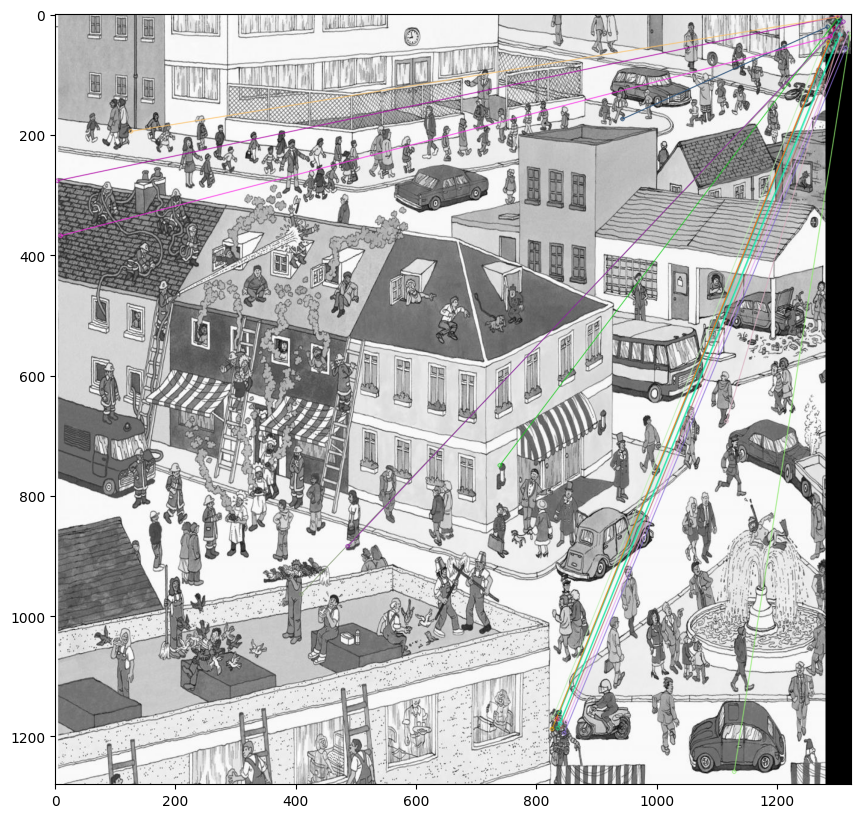

In [8]:
print(k_1[matches[1].queryIdx].size)
matches = sorted(matches, key=lambda x: x.distance)
image_with_matches = cv2.drawMatches(gray_img, k_1, template_scale, k_2, matches[:20], template_scale, flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_matches, cv2.COLOR_BGR2RGB))

Для большей устойчивости определения соответствия точек может использоваться knnMatch, с параметром k, который определяет не только ближайшее совпадение для каждой точки шаблона, но и k ближайших.
Теперь кортеж DMatch будет многомерным (двумерным, если k=2),так как каждой точке шаблона соответствует несколько точек изображения.
Лучшие пары особых точек отбираются с использованием теста отношения правдоподобия

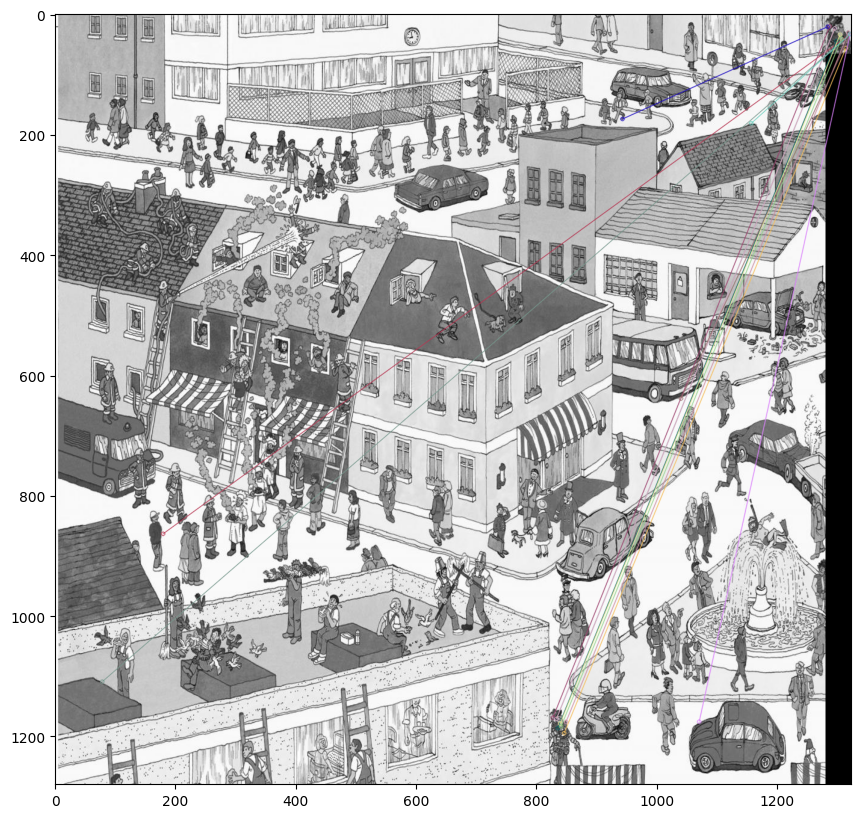

In [9]:
bf = cv2.BFMatcher(cv2.NORM_L1)
matches = bf.knnMatch(des_1, des_2, k=2)

# Лучшие пары особых точек отбираются с использованием теста отношения правдоподобия
good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append([m])

# построим совпадения на изображении
image_with_knn_matches = cv2.drawMatchesKnn(gray_img,k_1,template_scale,k_2,good[:200],None,flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_knn_matches, cv2.COLOR_BGR2RGB))


Для определения локализации объектов применим алгоритм кластеризации особых точек.
Идея состоит в том, что в области объекта концентрация особых точек будет выше.

In [10]:
points = np.array([(0, 0)])
for i in good:
    points = np.append(points, [k_1[i[0].queryIdx].pt], axis=0)

points = points[1:len(points)]


#print(f"Всего точек: {len(points)}")
#print(f"Уникальных точек: {len(np.unique(points, axis=0))}")

points = np.unique(points, axis=0)



In [11]:

# Определяем ширину окна и запускаем алгоритм кластеризации
bandwidth = estimate_bandwidth(points, quantile=0.2)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False)
cl = ms.fit_predict(points)
bandwidth

np.float64(131.1340389731429)

In [12]:

# Формируем кластеры особых точек
labels_unique = np.unique(ms.labels_)
kp = []
for i in labels_unique:
    kp.append(points[cl==i])

# Определяем центры кластеров, но только если в кластере содержится более 6 точек
cen = []
for i in kp:
    if len(i)>6:
        cen.append(np.mean(i, axis=0).astype(np.uint16))

cen


[array([ 838, 1180], dtype=uint16)]

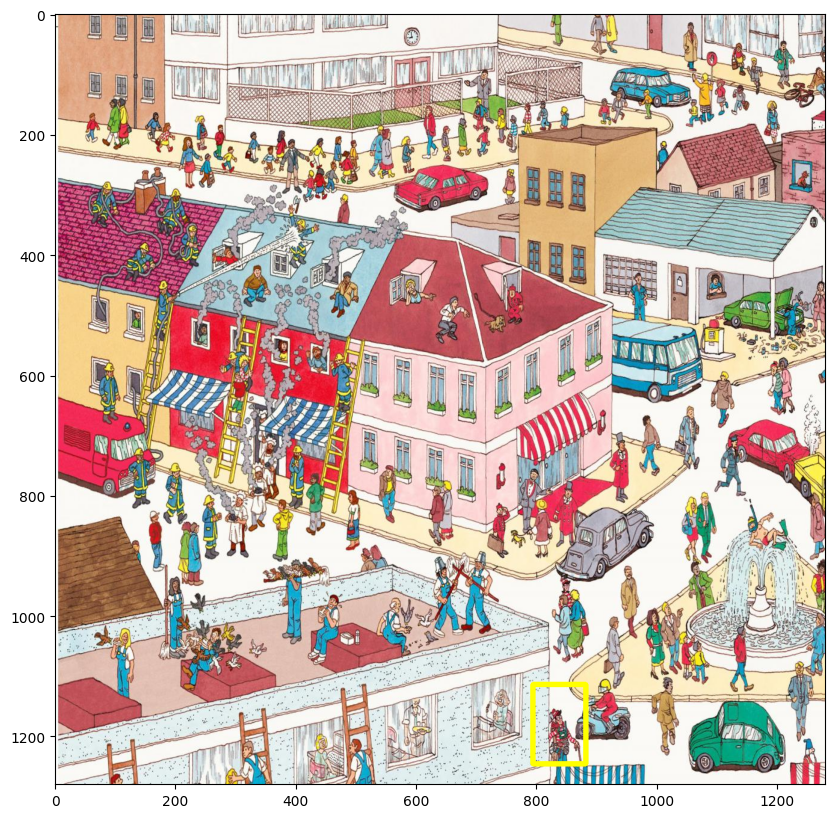

In [13]:

# Вокруг выделенных центров обводим прямоугольники с размерами шаблона
plot_img = rgb_img.copy()
h, w = template_scale.shape

for pt in cen:
    cv2.rectangle(plot_img, (pt[0] - w, pt[1] - h),(pt[0] + w, pt[1] + h),(0,255,255), 8)

# Отображаем результат на графике
plt.figure()
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))

Нашелся!